In [1]:
import pandas as pd
import numpy as np
import networkx as nx


In [2]:
# Load expression data
expr = pd.read_csv("../data/processed/expression_matrix_clean.csv", index_col=0)

# Load significant genes
sig = pd.read_csv("../results/significant_genes.csv")

sig.shape


(106, 4)

In [3]:
sig_genes = sig["gene"].values

expr_sig = expr.loc[sig_genes]

expr_sig.shape


(106, 624)

In [4]:
labels = pd.read_csv("../data/processed/sample_labels.csv")

ad_samples = labels[labels["status"] == "AD"]["sample_id"]
control_samples = labels[labels["status"] == "Control"]["sample_id"]

expr_ad = expr_sig[ad_samples]
expr_control = expr_sig[control_samples]


In [5]:
corr_ad = expr_ad.T.corr()
corr_control = expr_control.T.corr()


In [6]:
THRESHOLD = 0.7


In [7]:
G_ad = nx.Graph()

for i in corr_ad.index:
    for j in corr_ad.columns:
        if i != j and abs(corr_ad.loc[i, j]) >= THRESHOLD:
            G_ad.add_edge(i, j, weight=corr_ad.loc[i, j])


In [8]:
G_ctrl = nx.Graph()

for i in corr_control.index:
    for j in corr_control.columns:
        if i != j and abs(corr_control.loc[i, j]) >= THRESHOLD:
            G_ctrl.add_edge(i, j, weight=corr_control.loc[i, j])


In [9]:
G_ad.number_of_nodes(), G_ad.number_of_edges()
G_ctrl.number_of_nodes(), G_ctrl.number_of_edges()


(105, 1521)

In [10]:
deg_ad = nx.degree_centrality(G_ad)
deg_ctrl = nx.degree_centrality(G_ctrl)


In [11]:
bet_ad = nx.betweenness_centrality(G_ad)
bet_ctrl = nx.betweenness_centrality(G_ctrl)


In [12]:
hub_diff = []

for gene in deg_ad:
    if gene in deg_ctrl:
        hub_diff.append({
            "gene": gene,
            "degree_AD": deg_ad[gene],
            "degree_Control": deg_ctrl[gene],
            "degree_diff": deg_ad[gene] - deg_ctrl[gene]
        })

hub_df = pd.DataFrame(hub_diff)
hub_df.sort_values("degree_diff", ascending=False).head(10)


,gene,degree_AD,degree_Control,degree_diff
57,10023833115,0.45,0.230769,0.219231
61,10025908848,0.42,0.211538,0.208462
39,10023814509,0.40,0.211538,0.188462
40,10023814510,0.37,0.182692,0.187308
34,10023811933,0.41,0.259615,0.150385
12,10023820660,0.18,0.076923,0.103077
73,10033668859,0.46,0.384615,0.075385
67,10025911973,0.43,0.355769,0.074231
8,10023805853,0.21,0.153846,0.056154
18,10025903318,0.17,0.115385,0.054615


In [13]:
hub_df.to_csv("../results/network_hub_comparison.csv", index=False)
nx.write_gml(G_ad, "../results/alzheimers_network.gml")
nx.write_gml(G_ctrl, "../results/control_network.gml")


In [15]:
import matplotlib.pyplot as plt
import networkx as nx


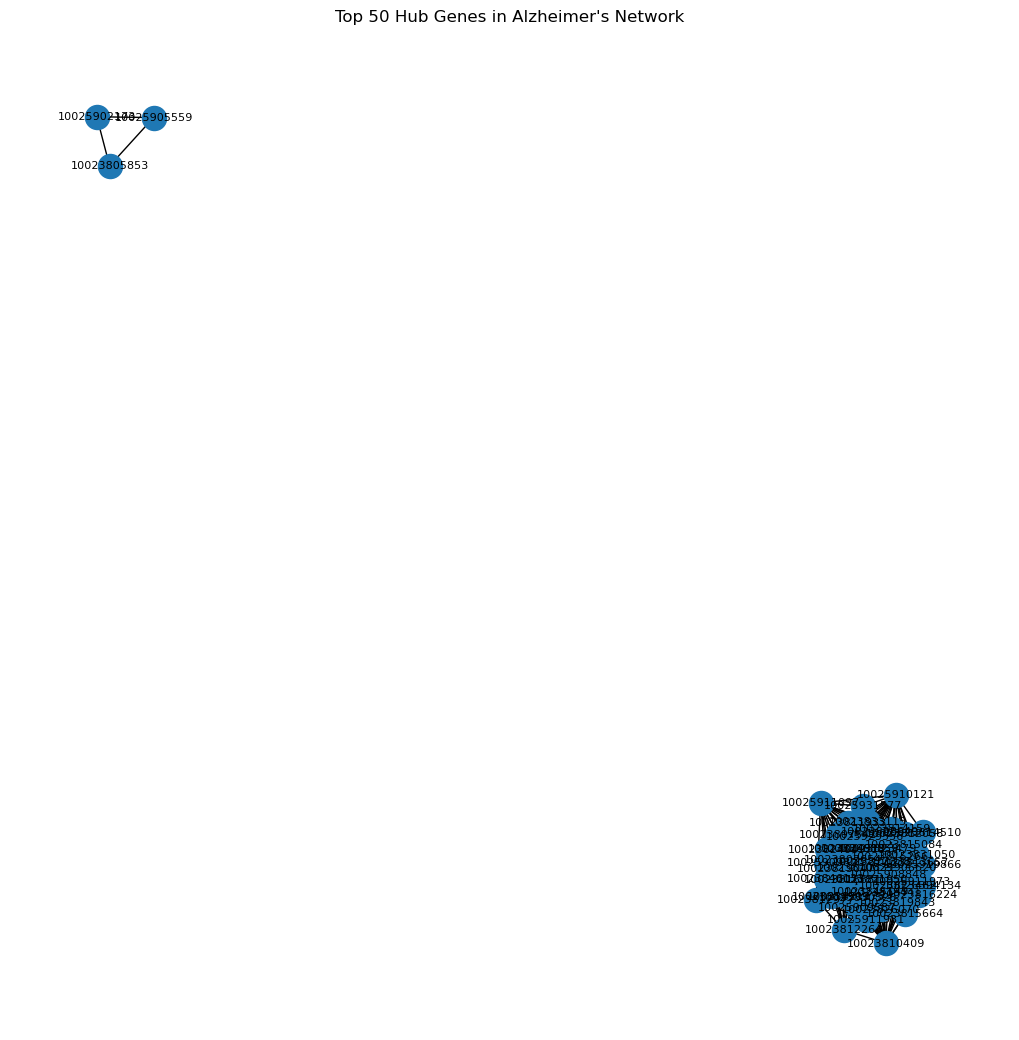

In [16]:
top_genes = (
    hub_df.sort_values("degree_AD", ascending=False)
    .head(50)["gene"]
)

G_sub = G_ad.subgraph(top_genes)

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G_sub, seed=42)

nx.draw(
    G_sub, pos,
    with_labels=True,
    node_size=300,
    font_size=8
)

plt.title("Top 50 Hub Genes in Alzheimer's Network")
plt.show()
